# Pytorch MNIST
---
by Pranpaveen Lay.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/layel2/pytorch-course/blob/main/5.pytorch-mnist.ipynb)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [3]:
data_train = torchvision.datasets.MNIST('./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
data_test = torchvision.datasets.MNIST('./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

In [4]:
data_train,data_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
data_train.data.shape

torch.Size([60000, 28, 28])

In [9]:
loader_train = torch.utils.data.DataLoader(data_train,batch_size=64)
loader_test = torch.utils.data.DataLoader(data_test,batch_size=64)

In [11]:
#examples = enumerate(loder_test)
for example_data, example_targets in loader_test :
    break

In [12]:
example_data.shape

torch.Size([64, 1, 28, 28])

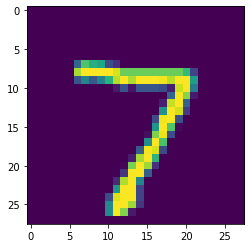

In [13]:
plt.imshow(example_data[0][0])

## Building model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Sequential

In [15]:
model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(in_features=64 * 12 * 12, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=10),
            nn.LogSoftmax()
        )

### Model Class

In [16]:
class mnistmodel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2)
        self.dense1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
        self.dense2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.dropout(x, 0.25)
        x = nn.Flatten()(x)
        x = F.relu(self.dense1(x))
        x = F.dropout(x, 0.5)
        x = self.dense2(x)
        x = F.log_softmax(x)

        return x

In [17]:
model2 = mnistmodel_2()

In [98]:
from torchsummary import summary

In [99]:
summary(model.to(device),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 12, 12]         102,464
              ReLU-4           [-1, 64, 12, 12]               0
           Dropout-5           [-1, 64, 12, 12]               0
           Flatten-6                 [-1, 9216]               0
            Linear-7                  [-1, 128]       1,179,776
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,285,194
Trainable params: 1,285,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [100]:
summary(model2.to(device),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
            Conv2d-2           [-1, 64, 12, 12]         102,464
            Linear-3                  [-1, 128]       1,179,776
            Linear-4                   [-1, 10]           1,290
Total params: 1,285,194
Trainable params: 1,285,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 4.90
Estimated Total Size (MB): 5.36
----------------------------------------------------------------


<ipython-input-96-707fbf24421e>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


## Define function

In [101]:
def test(model,loader,verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(loader.dataset)
        test_acc = 100. * correct / len(loader.dataset)
        if verbose:
            print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({test_acc:.2f}%)\n')
        return test_loss, test_acc.item()

In [102]:
test(model,loader_test)


Test set: Avg. loss: 2.2999, Accuracy: 1112/10000 (11.12%)



(2.299892060852051, 11.119999885559082)

In [103]:
train_losses = []
test_losses = []
n_epochs = 10

In [104]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [105]:
loss_fn = nn.NLLLoss()

In [106]:
log_interval = 100
def train(epoch,model=model,loader_train=loader_train, loss_fn = loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(loder_train):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loder_train.dataset),
                100. * batch_idx / len(loder_train), loss.item()))
            #train_losses.append(loss.item())
    train_loss,train_acc = test(model,loader_train, verbose=False)
    test_loss,test_acc = test(model,loader_test, verbose=False)
    train_losses.append([train_loss,train_acc])
    test_losses.append([test_loss,test_acc])
    print(f"epoch {epoch} : train_loss {train_loss:.6f}, train_acc {train_acc:.2f}, eval_loss {test_loss:.6f}, eval_acc {test_acc:.2f}")


In [109]:
for epoch in range(n_epochs):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299212
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.401241
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.209234
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.203193
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.124270
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.170510
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.056962
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.117220
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.171370
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.108842
epoch 0 : train_loss 0.052485, train_acc 98.40, eval_loss 0.050604, eval_acc 98.25
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.065228
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.148472
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.061367
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.094216
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.027810
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.063412
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.119736
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.084769
Train Epoch: 1 [51200/60000 (

Text(0.5, 1.0, 'Loss')

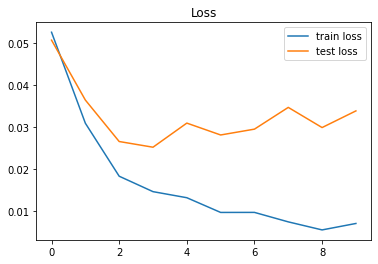

In [118]:
plt.plot(np.array(train_losses)[:,0])
plt.plot(np.array(test_losses)[:,0])
plt.legend(['train loss','test loss'])
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

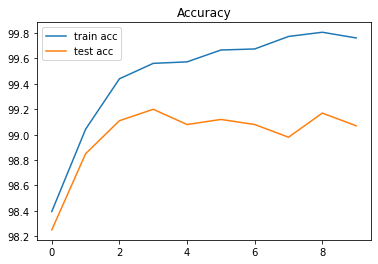

In [119]:
plt.plot(np.array(train_losses)[:,1])
plt.plot(np.array(test_losses)[:,1])
plt.legend(['train acc','test acc'])
plt.title('Accuracy')

## save model

In [120]:
!mkdir saved_model

In [122]:
torch.save(model, 'saved_model/minst_model.pth')

In [123]:
torch.save(model.state_dict(), 'saved_model/mnist_model_weights.pth')

In [124]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[[[-2.7283e-02, -6.6340e-03, -9.0487e-02, -1.7480e-01, -2.1224e-02],
                        [ 9.0531e-03, -2.3170e-01,  1.3217e-01, -2.5431e-01, -8.1370e-02],
                        [-6.5894e-02,  4.3826e-02, -2.9531e-02, -2.6834e-01,  5.7490e-02],
                        [ 8.1304e-02,  5.8267e-02,  9.4254e-02,  4.7415e-02, -2.4879e-02],
                        [ 7.2475e-02, -3.2886e-01,  1.8593e-02, -8.5981e-02, -6.5493e-02]]],
              
              
                      [[[-2.4836e-01, -2.0884e-01,  2.7005e-02,  9.1598e-02,  1.5290e-01],
                        [-2.9212e-01, -1.8719e-01, -3.6046e-02,  2.4512e-01, -1.7612e-01],
                        [-6.9641e-02, -3.9524e-02,  2.7041e-02,  2.1317e-02, -4.3204e-02],
                        [-2.3623e-01, -2.3357e-01, -2.9267e-02,  4.8875e-02,  8.9480e-02],
                        [-1.8332e-01, -2.6925e-01, -2.6743e-01, -2.7717e-01, -1.2343e-01]]],
              
              


In [18]:
torch.save(model2, 'saved_model/minst_model_class.pth')
torch.save(model2.state_dict(), 'saved_model/mnist_model_class_weights.pth')